In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


plt.style.use("fivethirtyeight")

In [2]:
import edward as ed
import tensorflow as tf

# Estimating mean

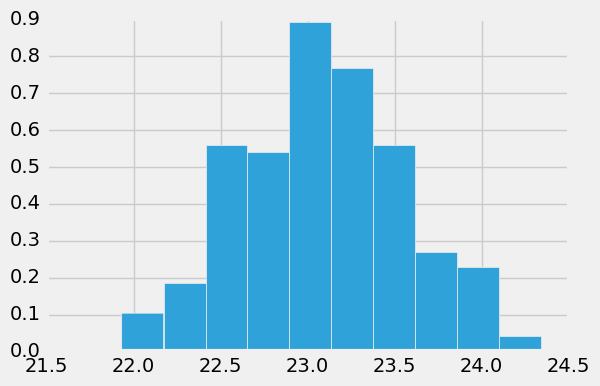

In [3]:
N = 200    # number of observations

x_true = 23.1
sigma_x = 0.5
x_train = np.random.normal(x_true, sigma_x, size=N)

plt.hist(x_train, normed=True);

In [54]:
sess = tf.InteractiveSession()

In [55]:
# uniform prior from zero to 100 (both works)
mux = ed.models.Uniform(a=tf.constant(0.), b=tf.constant(100.))
# mux = ed.models.Uniform(a=0., b=100.)

# Gaussian noise model for observations
x = ed.models.Normal(mu=mux*tf.ones(N), sigma=tf.constant(sigma_x))

# Define variational model for mux
# tf.Variable is not initialized when you call it -- evaluating will raise uninitialized error
# They are used for parameters to be trained.
# The following initalizes two variables with random initial value
# qmu_mu = tf.Variable(tf.random_normal([]))
# qmu_sigma = tf.nn.softplus(tf.Variable(tf.random_normal([])))
# Equavalent to:
qmu_mu = tf.Variable(0.)
qmu_sigma = tf.nn.softplus(tf.Variable(3.))
# NOTE: tf.nn.softplus keeps the sigma of gaussian positive
qmu = ed.models.Normal(mu=qmu_mu, sigma=qmu_sigma)

In [56]:
# Define inference for the posterior of mux conditioned on data for x
# with the variational model qmu
inference = ed.KLqp({mux:qmu}, data={x: x_train})

In [57]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 217.330


In [62]:
# Now that qmu is trained with the data to approximate the posterior of mux
print(sess.run([qmu.mu, qmu.sigma, qmu_mu, qmu_sigma]))
# Use sample method to generate sample of mux
mux_post_sample = sess.run(qmu.sample(1000))

[23.083031, 0.41275647, 23.083031, 0.41275647]


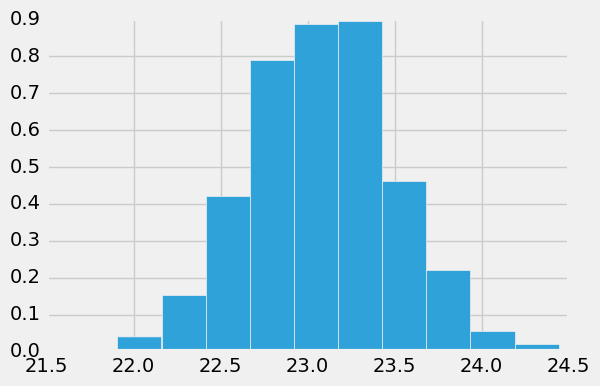

In [63]:
plt.hist(mux_post_sample, normed=True);

In [8]:
x_post = ed.copy(x, {mux:qmu})

In [34]:
x_post = ed.models.Normal(mu=qmu, sigma=tf.constant(sigma_x))

# Fit a line

$ y_i = w x_i + b $

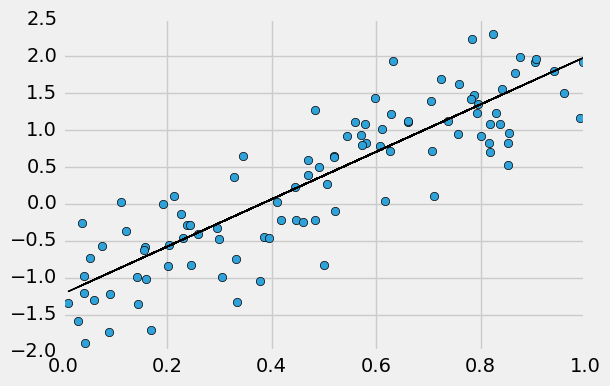

In [295]:
N = 100  # number of data points

w_true = 3.21
b_true = -1.22

x_train = np.random.uniform(size=(N))
sigma_y = np.random.uniform(size=(N))
sigma_y = np.zeros(N)+.5
y_train = np.random.normal(w_true*x_train + b_true, sigma_y)

plt.plot(x_train, y_train, 'o');
plt.plot(x_train, w_true*x_train+b_true, 'k-', lw=1);

In [296]:
# prior for w and b
# w = ed.models.Normal(mu=0., sigma=10.)
# b = ed.models.Normal(mu=0., sigma=10.)
w = ed.models.Uniform(-10.,10.)
b = ed.models.Uniform(-10.,10.)

# we need a placeholder for the data to define our model
# need to match dtype!
X = tf.placeholder(tf.float32, [N])
y = ed.models.Normal(mu=X*w+b, sigma=tf.constant(sigma_y, tf.float32))

# variational model
qw = ed.models.Normal(mu=tf.Variable(0.),
                      sigma=tf.nn.softplus(tf.Variable(tf.random_normal([]))))
qb = ed.models.Normal(mu=tf.Variable(0.),
                      sigma=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

In [297]:
inference = ed.KLqp({w:qw, b:qb}, data={X: x_train, y:y_train})

In [298]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 84.721


In [299]:
sess.run([qw.mu, qw.sigma, qb.mu, qb.sigma])

[3.2341077, 0.087980866, -1.2787459, 0.054478586]

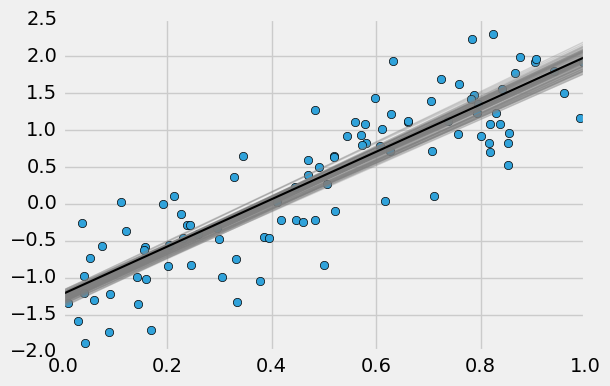

In [300]:
plt.plot(x_train, y_train, 'o');


n_sample = 100
w_post_sample, b_post_sample = sess.run([qw.sample(n_sample), qb.sample(n_sample)])
xx = np.linspace(0,1,10)

for ww,bb in zip(w_post_sample, b_post_sample):
    plt.plot(xx, ww*xx+bb, color='gray', alpha=.3, lw=1);
plt.plot(xx, w_true*xx+b_true, 'k-', lw=1.5);

In [199]:
# infer something that's observed as inverse of the true value like parallax
# doesn't work so well because the gaussian variational model is actually bad for this case.


# d = ed.models.Normal(mu=35., sigma=tf.nn.softplus(tf.random_normal([])))
d = ed.models.Uniform(5.,50.)
sigp = tf.placeholder(tf.float32, [1])
p = ed.models.Normal(mu=mux*tf.ones(1), sigma=sigp)

qd = ed.models.Normal(mu=32.,
                      sigma=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

In [200]:
inference = ed.KLqp({d:qd}, data={p:[30.], sigp:[0.1]})

In [201]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 28428.146


In [202]:
sess.run([qd.mu, qd.sigma])

[32.0, 23.989618]

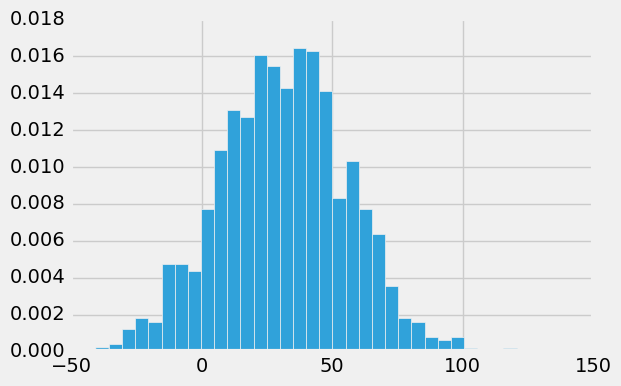

In [207]:
plt.hist(qd.sample(1000).eval(), 32, normed=True);

# MC

In [208]:
from edward.models import Normal, Empirical

In [234]:
z = Normal(mu=0.0, sigma=1.0)
x = Normal(mu=tf.ones(10) * z, sigma=1.0)

qz = Empirical(tf.Variable(tf.zeros(500)))
data = {x: np.array([2.34] * 10, dtype=np.float32)}
inference = ed.HMC({z: qz}, data)

In [235]:
inference.run()

500/500 [100%] ██████████████████████████████ Elapsed: 4s | Acceptance Rate: 0.936


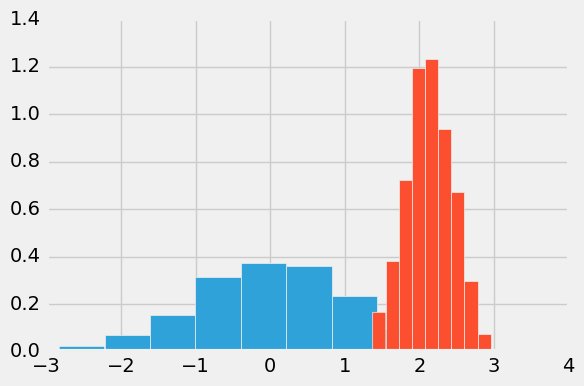

In [236]:
plt.hist(z.sample(1000).eval(), normed=True)
plt.hist(qz.sample(1000).eval(), normed=True);

In [274]:
# d = ed.models.Normal(mu=35., sigma=tf.nn.softplus(tf.random_normal([])))
d = ed.models.Uniform(0.1,50.)
d_true=31.23
sigp = tf.placeholder(tf.float32, [1])
p = ed.models.Normal(mu=mux*tf.ones(1), sigma=sigp)

# qd = Empirical(tf.Variable(tf.random_uniform([500], 5, 50)))
qd = Empirical(tf.Variable(tf.ones(500)*d_true))

inference = ed.HMC({d:qd}, {p:[1./d_true], sigp:[0.1*1./d_true]})

In [278]:
inference.run(step_size=0.1)

500/500 [100%] ██████████████████████████████ Elapsed: 4s | Acceptance Rate: 0.531


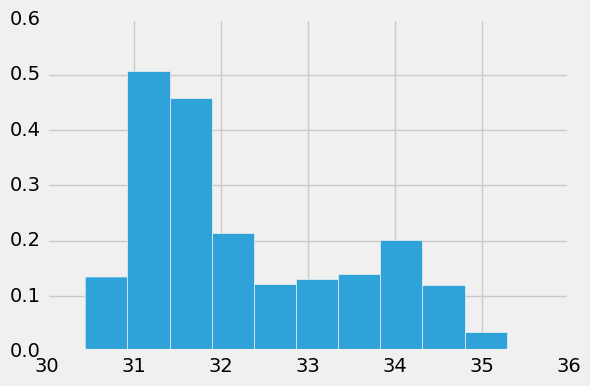

In [279]:
# plt.hist(d.sample(1000).eval(), normed=True)
plt.hist(qd.sample(5000).eval(), normed=True);

## Fit a line, this time sample

In [369]:
# prior for w and b
# w = ed.models.Normal(mu=0., sigma=10.)
# b = ed.models.Normal(mu=0., sigma=10.)
w = ed.models.Uniform(-10.,10.)
b = ed.models.Uniform(-10.,10.)

# we need a placeholder for the data to define our model
# need to match dtype!
X = tf.placeholder(tf.float32, [N])
y = ed.models.Normal(mu=X*w+b, sigma=tf.constant(sigma_y, tf.float32))

# variational model
# qw =  Empirical(tf.Variable(tf.ones(5000)*w_true))
# qb =  Empirical(tf.Variable(tf.ones(5000)*b_true))
qw =  Empirical(tf.Variable(np.random.uniform(-2,4,10000), dtype=tf.float32))
qb =  Empirical(tf.Variable(np.random.uniform(-2,4,10000), dtype=tf.float32))

In [370]:
inference = ed.HMC({w:qw, b:qb}, {X: x_train, y:y_train})

In [371]:
inference.run(step_size=0.01)

10000/10000 [100%] ██████████████████████████████ Elapsed: 41s | Acceptance Rate: 0.998


In [381]:
print(qw.mean().eval(), qw.std().eval(), qb.mean().eval(), qb.std().eval())
print(qw.params.eval()[2000:].mean(),
      qw.params.eval()[2000:].std(),
      qb.params.eval()[2000:].mean(),
      qb.params.eval()[2000:].std())

3.10685 0.492327 -1.20834 0.265044
3.20216 0.179366 -1.25801 0.102666


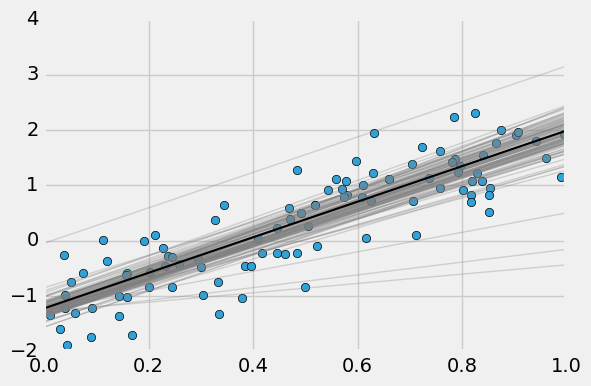

In [373]:
plt.plot(x_train, y_train, 'o');


n_sample = 100
w_post_sample, b_post_sample = sess.run([qw.sample(n_sample), qb.sample(n_sample)])
xx = np.linspace(0,1,10)

for ww,bb in zip(w_post_sample, b_post_sample):
    plt.plot(xx, ww*xx+bb, color='gray', alpha=.3, lw=1);
plt.plot(xx, w_true*xx+b_true, 'k-', lw=1.5);

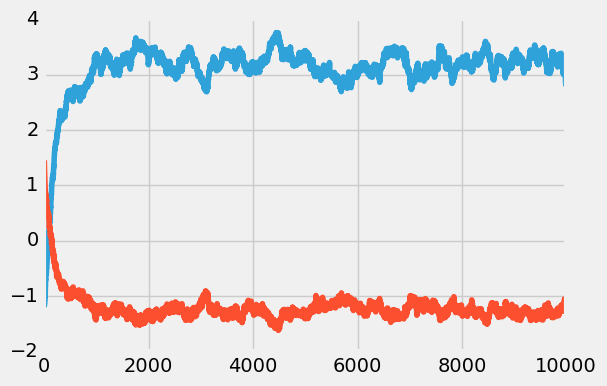

In [378]:
plt.plot(qw.params.eval());
plt.plot(qb.params.eval());

In [386]:
w_sample = qw.params.eval()[:]
b_sample = qb.params.eval()[:]

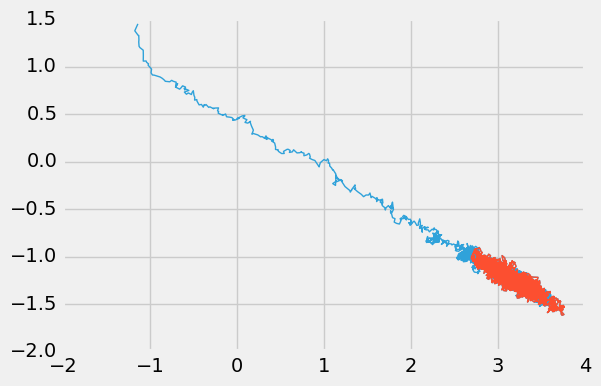

In [389]:
plt.plot(w_sample, b_sample, lw=1.)
plt.plot(w_sample[2000:], b_sample[2000:], lw=1)

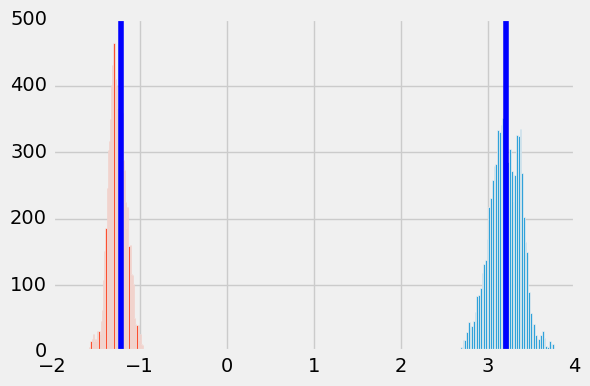

In [380]:
plt.hist(qw.params.eval()[2000:], 54);
plt.axvline(w_true,);
plt.hist(qb.params.eval()[2000:], 54);
plt.axvline(b_true,);